# Segmentez des clients d'un site e-commerce

<img src="logo_OLIST.png" alt="logo_OLIST" width="300" class="center"/>

# Troisième Partie - Proposition d'un contrat de maintenance

Dans la partie précédente nous avons proposé un modèle de clustering basé sur les features `R` (récense), `F` (fréquence), `M` (montant), `DELAY` (écart date livraison prévue/réelle) et `review_score` (dernière note commande).

Le modèle `KMeans` retenu et les 5 clusters proposés (*dépensiers*, *récurrents*, *ex-clients*, *nouveaux clients*, *clients mécontents et/ou avec retard*) ont été **déterminés sur les données à date**. L'**enjeu** pour l'entreprise est de **maintenir cette segmentation pertinente au cours du temps**, qu'elle puisse s'adapter :
- nouveau client
- changement de profil d'un client existant
- évolution naturelle de `R`
- nouvelle commande
- etc.

Cette **adaptation passe par une mise à jour du modèle**, et la problématique qui se pose alors est : à **quelle fréquence** *Olist* devra mettre à jour sa segmentation ?

# 1) Préambule

## 1.1) Quelle méthodologie ?

Pour déterminer une fréquence de maintenance, nous devons **réaliser des tests**. Pour cela nous comparerons deux cas de figure :
- **cas 1 - pas de mise à jour** : les données relatives aux commandes, et mises à jours au cours du temps, sont transmises au modèle déjà entraîné. La segmentation proposée alors tient compte des anciennes données
- **cas 2 - mise à jour** : les données à jours sont d'abord utilisées pour ré-entraîner le modèle. Après cette étape la segmentation est générée

On comprend que **ces 2 cas peuvent produire des segments relativement différents**. 

Un afflux de commandes au `M` très élevé pourrait par exemple modifier la manière dont les données sont standardisées puis segmentées, modifiant la limite entre les clients *dépensiers* et les autres. Une fréquence de maintenance extrêmement grande, par exemple 1 an, pourrait avoir un effet similaire sur `R`, etc.

A l'inverse, une fréquence extrêmement faible n'aura pas vraiment d'effet, les données utilisées pour pour le nouvel entraînement étant pratiquement les mêmes que celles utilisées pour le précédent modèle.

Pour réaliser nos tests nous utiliserons notre jeu de données en **le filtrant par date**. Nous pourrons **ainsi simuler artificiellement la création d'un modèle dans le passé, puis sa mise à jour successive à une fréquence donnée**.

## 1.2) Quelle mesure ?

Afin de comparer le cas 1 et le cas 2, nous utiliserons la **version "ajustée" de l'*indice de Rand***.

L'*indice de Rand* est une **mesure de similarité** entre deux segmentations d'un même jeu de données. Il s'agit de la **proportion de paires d'observations** :
- soit **faisant partie d'un même cluster dans la segmentation 1 ET dans la segmentation 2**
- soit **séparées dans la segmentation 1 et dans la segmentation 2**

Si *RI* = 1, les segmentations sont similaires. Si *RI* = 0, c'est l'inverse.

On parle de version "ajustée" car l'***indice de Rand* classique a des défauts** :
- son **espérance** dans le cas de **deux segmentations aléatoires n'est pas constante** (on aimerait par exemple qu'elle soit alors toujours de 0.5). Elle dépend de la population de chaque cluster, de chaque segmentation ...
- il est facile de **"tricher"** : en **augmentant substantiellement le nombre de clusters**, le nombre de paires d'observations rentrant dans la catégorie *"séparées dans la segmentation 1 et dans la segmentation 2"* sera très important...

l'*ARI* est donnée par :
$ \frac{RI - E(RI)}{max(RI) - E(RI)}$

Son **espérance est maintenant de 0 pour des segmentations aléatoires**. Il peut prendre des **valeurs négatives** (pour des segmentations très différentes) et est toujours **égal à 1** pour des segmentations similaires.

Pour notre étude nous considérerons deux segmentations comme suffisemment similaires **si leur *ARI* est supérieur ou égal à 0.9**.

## 1.1) Import des librairies

In [1]:
# data manipulation
import pandas as pd  # to manipulate the dataset with dataframes
from dateutil import relativedelta
import numpy as np  # for statistics and calculations

# data visualisation
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.ticker as mtick  # for format axis in percent %
from matplotlib.patches import Patch  # for custom legends
import seaborn as sns
import plotly.express as px

# interactive displays
import ipywidgets as widgets

# files management
import os  # for folders management
import sys  # for memory management
import gc  # for memory management
from joblib import dump, load  # to make saves


# custom functions
import myFunctions as mf

# scikit learn

# preprocessing tools
from sklearn.preprocessing import StandardScaler

# pipeline tools
from sklearn.pipeline import Pipeline

# for dimensionality reduction
from sklearn.manifold import TSNE
from openTSNE.sklearn import TSNE as openTSNE  # openTSNE (quicker)

# for clustering
# metrics
from sklearn.metrics import adjusted_rand_score

# models
from sklearn.cluster import KMeans

# execution time
import time

start_time = time.time()

# pip list

In [2]:
# set theme
sns.set_theme(style="whitegrid")

## 1.2) Options du notebook & sauvegardes

Afin de réduire le temps d'exécution lors du développement du projet, nous avons utilisé les fonctions `dump` et `load` de `joblib`. 
Les enregistrements sont inclus dans le dossier `/mySaves`.

**Le notebook n'a pas besoin de ce dossier pour fonctionner**. Le temps d'exécution sera en revanche **plus long** lors de la première exécution.

L'option `rapidProcessing` peut être désactivée pour ignorer les sauvegardes (et les recréer après des modifications par exemple).

In [3]:
# create folders for savings
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/maintenance"):
    os.mkdir("mySaves/maintenance")

In [4]:
# option, wether or not to use saves
rapidProcessing = True

Pour les représentations graphiques, nous attribuons à chaque cluster une couleur distincte :

In [5]:
# make a color palette for clusters
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "gold",
    "coral",
    "deepskyblue",
    "limegreen",
    "peru",
]
clusterPalette = {i: color for i, color in enumerate(colors)} | {-1: "black"}

## 1.3) Imports du dataset unifié des commandes

In [6]:
# import dataOrd file

if "dataOrd.joblib" in os.listdir("mySaves/dataset_by_orders"):
    dataOrd = load("mySaves/dataset_by_orders/dataOrd.joblib")
else:
    print("attention la sauvegarde du dataset unifié n'est pas présente")

# 2) Filtrage par date

Nous allons devoir étudier la **stabilité** de notre clustering **au cours du temps**. Nous devrons donc simuler l'évolution de la base de données OLIST afin de prendre en compte les **nouveaux clients**, ou encore l'**évolution du comportement des clients actuels**.

La première étape est donc de pouvoir générer notre dataset `R`, `F`, `M`, `DELAY`, `REVIEW_SCORE` pour différentes dates. Pour cela nous allons :
- tout d'abord filtrer le dataset des commandes `dataOrd` sur des dates antérieures à une date donnée
- recréer la feature `NEW_RECENCE_MONTHS` afin qu'elle reflète l'état de chaque commande à la date prise en référence
- agréger nos données sur les `customer_unique_id`
- effectuer le traitement sur les outliers avec la fonction `clip`

In [7]:
def get_RFMDR_date(T_past, samples=None, random_state=16):
    """
    a function to generate RFMDR (R, F, M, DELAY, REVIEW_SCORE) in the past :
                - first, filter the orders dataset dataOrd on past dates
                - then, aggregations to create our features

    parameters :
    ------------
    T_past - datetime :
    samples - int or list or None :
                        int : the number of clients (rows) in RFMDR
                        list : list of clients IDs to keep in RFMDR
                        None : all clients
                    By default : None
    random_state - int :
    """

    # filter dataOrd on older "order_purchase_timestamp"
    mask = dataOrd["order_purchase_timestamp"] < T_past
    dataOrdPast = dataOrd.copy()
    dataOrdPast = dataOrdPast.loc[mask]

    ## select clients
    if type(samples) == int:
        # aggregate on "customer_unique_id"
        clients = (
            dataOrdPast[["customer_unique_id"]]
            .groupby("customer_unique_id", as_index=False, observed=True)
            .first()
        )
        # keep the Series
        clients = clients["customer_unique_id"]
        # update sample if not enough rows
        samples = min(samples, len(clients))
        # sample
        clients = clients.sample(n=samples, random_state=random_state).to_list()
        # create a mask
        mask = dataOrdPast["customer_unique_id"].isin(clients)
        # filter
        dataOrdSample = dataOrdPast.copy()
        dataOrdSample = dataOrdSample.loc[mask]
    elif type(samples) == list:
        # in that case, clients are in samples
        clients = samples
        # create a mask
        mask = dataOrdPast["customer_unique_id"].isin(clients)
        # filter
        dataOrdSample = dataOrdPast.copy()
        dataOrdSample = dataOrdSample.loc[mask]
    else:
        # in that case, no sampling
        dataOrdSample = dataOrdPast.copy()
        clients = None

    del dataOrdPast
    gc.collect()

    # update RECENCE

    # create a column with the time since purchase, relative to the most recent date of the dataset
    if len(dataOrdSample) > 0:
        dataOrdSample["NEW_RECENCE_MONTHS"] = (
            (
                dataOrdSample["order_purchase_timestamp"].max()
                - dataOrdSample["order_purchase_timestamp"]
            )
            .round("d")
            .dt.days
        )
        # convert in months
        dataOrdSample["NEW_RECENCE_MONTHS"] = (
            dataOrdSample["NEW_RECENCE_MONTHS"] / 365 * 12
        )
        # round
        dataOrdSample["NEW_RECENCE_MONTHS"] = round(
            dataOrdSample["NEW_RECENCE_MONTHS"], 2
        )

    ## aggregation
    # agg dictionnary
    aggDict = {
        "NEW_RECENCE_MONTHS": ["min"],
        "order_id": ["count"],
        "payment_value": ["sum"],
        "NEW_DELAY_DAYS": ["mean"],
        "review_score": ["first"],
    }

    # use .groupby, but first sort by 'order_purchase_timestamp' (to get most recent "review_score")
    RFMDR_past = (
        dataOrdSample.sort_values("order_purchase_timestamp", ascending=False)
        .groupby("customer_unique_id", as_index=True, observed=True)
        .agg(aggDict)
    )

    # correct columns index
    RFMDR_past.columns = pd.Index(e[0] for e in RFMDR_past.columns)

    RFMDR_past.rename(
        columns={
            "NEW_RECENCE_MONTHS": "R",
            "order_id": "F",
            "payment_value": "M",
            "NEW_DELAY_DAYS": "DELAY",
        },
        inplace=True,
    )
    ## outliers
    # clip "M" with 1000
    RFMDR_past["M"] = RFMDR_past["M"].clip(None, 1000)

    # clip "F" with 3
    RFMDR_past["F"] = RFMDR_past["F"].clip(None, 3)

    # change "review_score" dtype
    RFMDR_past["review_score"] = RFMDR_past["review_score"].astype("f")

    del dataOrdSample
    gc.collect()

    return RFMDR_past, clients

# 3) L'activité de l'entreprise au cours du temps

Nous allons tester différentes solutions pour la maintenance, c'est à dire différentes fréquences de mise-à-jour du modèle. L'enjeu est de pouvoir adapter la segmentation au cours du temps afin de refléter l'activité de l'entreprise, sans pour antant avoir à la mettre à jour trop fréquemment, ce qui serait coûteux pour l'entreprise.

Afin de nous rendre compte de l'ampleur de la tâche, regardons de plus prêt le nombre de commandes effectuées au cours du temps :

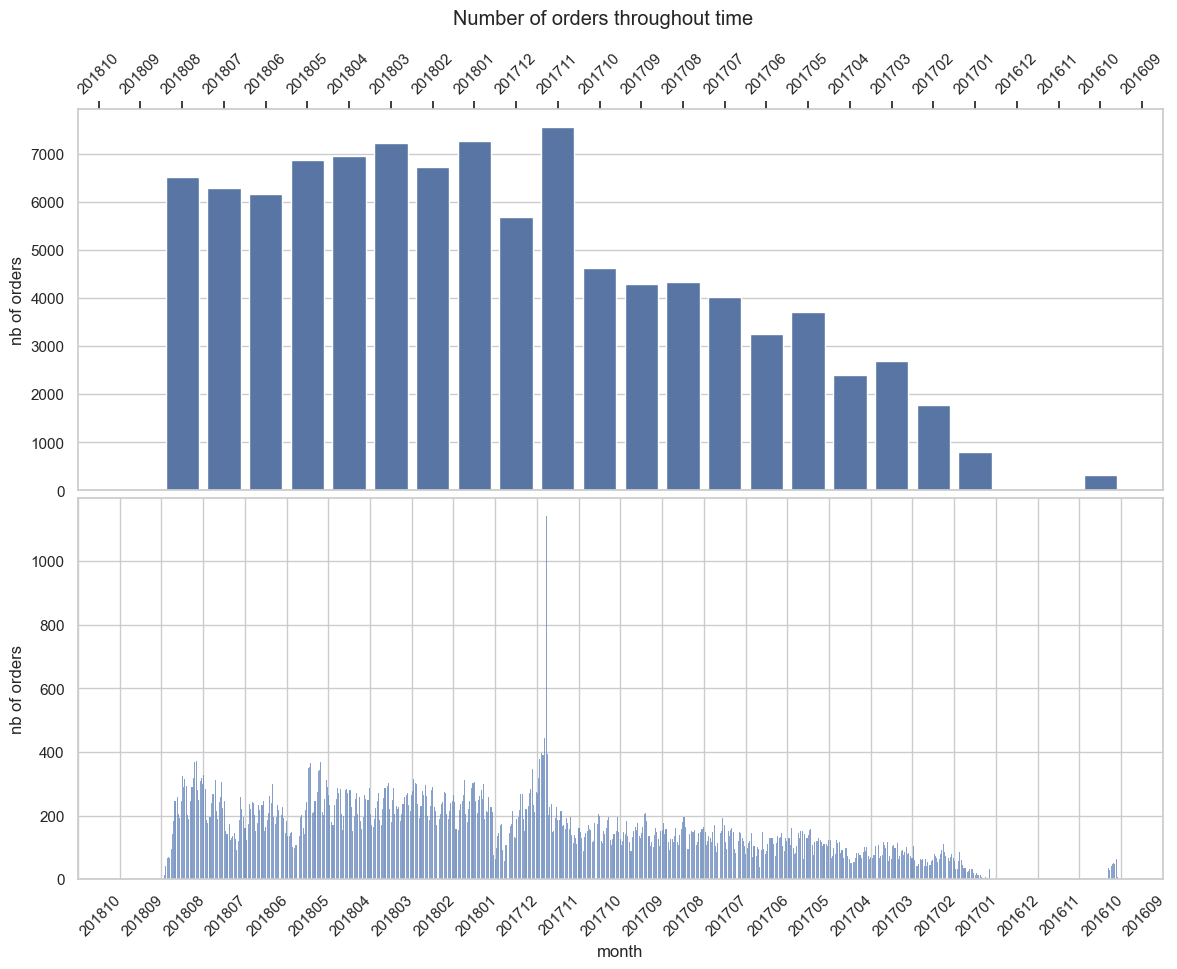

In [8]:
## plot the number of orders by month and the "NEW_RECENCE_MONTHS" histogram

## create a figure
fig, (ax_bar, ax_hist) = plt.subplots(2, 1, figsize=(14, 10))
fig.subplots_adjust(hspace=0.02)

## number of orders by month

# aggregate on "NEW_purchase_descrete_MONTH" to get the monthly number of orders
# create a copy
df = dataOrd[["customer_unique_id", "NEW_purchase_descrete_MONTH"]].copy()
# groupby month and count the number of rows
df = df.groupby("NEW_purchase_descrete_MONTH", as_index=False, observed=False).count()
# rename columns
df.columns = ["month", "nb of orders"]

# add a row for the month without any order
df.loc[len(df)] = [201611, 0]

# change the order of the "month" column
df = df.sort_values("month", ascending=False).reset_index(drop=True)
df["month"] = pd.Categorical(
    df["month"], categories=df["month"].to_list(), ordered=True
)

# plot
sns.barplot(data=df, x="month", y="nb of orders", ax=ax_bar)

# custom x ticks labels
ax_bar.set_xticks(
    ticks=[str(m) for m in df["month"].cat.categories],
    labels=df["month"].to_list(),
    rotation=45,
)
# move x ticks labels to the top
ax_bar.xaxis.set_ticks_position("top")

# remove x label
ax_bar.set_xlabel("")

## "NEW_RECENCE_MONTHS" histogram

# create a copy
recence = dataOrd["NEW_RECENCE_MONTHS"].copy()

# offset so the reference for recense=0 is the end of the most recent month
max = dataOrd["order_purchase_timestamp"].max()
maxEnd = max + relativedelta.relativedelta(day=31)
offset = (maxEnd - max).days
recence = recence + offset * 12 / 365

# plot
sns.histplot(recence, bins=1000, ax=ax_hist)

# set xticks so that they are similar to those from above barplot
maxRecenceCeil = int(np.ceil(recence.max()))
ax_hist.set_xticks(
    ticks=np.arange(maxRecenceCeil),
    labels=df["month"].to_list(),
    rotation=45,
    ha="left",
)

# set limits
ax_hist.set_xlim(0, maxRecenceCeil)

# set labels
ax_hist.set_xlabel("month")
ax_hist.set_ylabel("nb of orders")

# set title
fig.suptitle("Number of orders throughout time")

# show
plt.show()

Ce que l'on peut en retenir :
- Il n'y pas eu beaucoup d'activité lors des 2 derniers mois
- Il y a un pic d'activité il y a 11-12 mois
- entre ces deux périodes, le nombre de commandes fluctue
- il y a plus de 12 mois, l'activité était en croissance (en volume de commandes)

Notre simulation de maintenance devra donc permettre d'**éprouver ces différents types de configuration (pic, fluctuation, baisse d'acitivité, etc.)**. 

- les 5 premiers mois n'ont pas vraiment connu d'activité

Nous serons attentifs sur ces premiers mois, car ils doivent sans doute correspondre à un lancement et ne sont pas représentatifs de l'activité future de l'entreprise.

# 4) Test maintenance unique

L'objectif est de définir une fréquence de maintenance optimale pour notre modèle. Pour la choisir, nous allons la tester :
- en générant 2 `RFMDR`'s éloignés dans le temps de la fréquence à tester
- en créant un modèle sur les données récente et en générant les clusters (notre opération de Maintenance)
- en créant un modèle sur les données passées et s'en servant pour générer des clusters sur les données récentes (notre témoin)
- comparer ces clusterings grâce à l'`adjusted_rand_score` :
    - si le score n'est pas bon, les clusterings diffèrent trop et on peut en déduire que l'opération de maintenance a été peut-être trop tardive ...
    - si le score est bon alors la fréquence est sans doute pertinente.

Tout d'abord définissons quelques fonctions dont nous nous servirons par la suite :

## 4.1) Création de fonctions pour la simulation unique

Une fonction pour scaler un dataframe :

In [9]:
def myStandardScaler(scaler, df):
    """
    fit and transform a dataframe and return it as a dataframe

    parameters :
    ------------
    scaler - scikitlearn scaler
    df - dataframe

    return :
    --------
    the same dataframe, but scaled
    """

    # imports
    import pandas as pd

    # fit and tranform the df with the scaler
    # and return it as a dataframe

    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Une fonction pour "switcher" les labels d'un clustering sur la base d'un autre. Cette fonction servira surtout pour les représentations graphiques (les labels n'ont pas forcémment besoin de correspondre pour l'`ARI`).

In [10]:
def adjustClusterLabels(clusterSeriesBase, clusterSeriesToAdjust):
    """
    match labels between a base clusters Series and another which needs to be ajusted

    parameters :
    ------------
    clusterSeriesBase - Series : clusters with base labels names
    clusterSeriesToAdjust - Series : clusters with labels names needed to be adjusted

    return :
    --------
    clusterSeriesAjusted - Series : the same, with labels names adjusted
    """

    # imports
    import pandas as pd

    # create a copy of clusterSeriesToAdjust
    clusterSeriesAjusted = clusterSeriesToAdjust.copy()

    # iterate on the names of labels of the base Series
    for cBase in clusterSeriesBase.unique():
        # create a mask, rows where the base Series label is cBase
        mask = clusterSeriesBase == cBase
        # filter clusterSeriesToAdjust on these rows
        # and find the mode of its owns labels
        cToAdjust = clusterSeriesToAdjust.loc[mask].value_counts().index[0]
        # if labels are different, we can change this label name in clusterSeriesAjusted
        if cToAdjust != cBase:
            clusterSeriesAjusted.loc[clusterSeriesToAdjust == cToAdjust] = cBase
    return clusterSeriesAjusted

Nous pouvons maintenant nous concentrer sur l'opération de maintenance :

In [11]:
def getOldAndUpdatedClustering(df_before, df_now, returnDfs=False):
    """
    perform preprocessing and clustering on a RECENT dataframe, first fitted with its own caracteristics, simulating a maintenance operation.
    And another time, this time fitted with the caracteristics of an older dataframe, to compare.

    parameters :
    ------------
    df_before - dataframe : old data
    df_now - dataframe : up to date data
    returnDfs - bool : wether or not to return the different dataframes used for KMeans (fit and/or predict). By default - False

    return :
    --------
    clusters_now_old_settings - Series : clusters labels on recent data, but obtained with old settings
    clusters_now_updated_settings - Series : clusters labels on recent data
    dfs - dictionnary of dataframes : Optionnal (depends of returnDfs parameters). Contains :
            "now" : preprocessed df_now dataframe used for maintenance simulation
            "old" : preprocessed df_before dataframe used to configure the base model
            "nowOld" : preprocessed df_now, but preprocessed with older caracteristics. Used to predict base clustering

    """

    # scale
    sNow = StandardScaler()
    sBefore = StandardScaler()

    df_now_sNow = myStandardScaler(sNow, df_now)
    df_before_sBefore = myStandardScaler(sBefore, df_before)
    df_now_sBefore = pd.DataFrame(sBefore.transform(df_now), columns=df_now.columns)

    ## kmeans

    # initiate
    kmeans = KMeans(n_init=15, n_clusters=5, random_state=16)

    # predictions on old df, with old model, and put cluster labels in a Series
    kmeans.fit(df_before_sBefore)
    clusters_old_old_settings = kmeans.predict(df_before_sBefore)
    clusters_old_old_settings = pd.Categorical(clusters_old_old_settings)
    clusters_old_old_settings = pd.Series(
        clusters_old_old_settings, name="cluster_old_old"
    )

    # predictions on recent df, with old model
    # no fit
    clusters_now_old_settings = kmeans.predict(df_now_sBefore)
    clusters_now_old_settings = pd.Categorical(clusters_now_old_settings)
    clusters_now_old_settings = pd.Series(
        clusters_now_old_settings, name="cluster_now_old"
    )

    # predictions on recent df, with updated model
    kmeans.fit(df_now_sNow)
    clusters_now_updated_settings = kmeans.predict(df_now_sNow)
    clusters_now_updated_settings = pd.Categorical(clusters_now_updated_settings)
    clusters_now_updated_settings = pd.Series(
        clusters_now_updated_settings, name="cluster_now_updated"
    )

    # create dfs dictionnary (if necessary) and return outputs
    if returnDfs:
        dfs = {"now": df_now_sNow, "old": df_before_sBefore, "nowOld": df_now_sBefore}
        del df_now_sNow, df_before_sBefore, df_now_sBefore
        gc.collect()
        return (
            clusters_old_old_settings,
            clusters_now_old_settings,
            clusters_now_updated_settings,
            dfs,
        )
    else:
        del df_now_sNow, df_before_sBefore, df_now_sBefore
        gc.collect()

        return (
            clusters_old_old_settings,
            clusters_now_old_settings,
            clusters_now_updated_settings,
        )

Une fonction pour tracer le résultat d'un test de maintenance :

In [12]:
def plotClusteringOldAndUpdated(
    clusters_old_old_settings,
    clusters_now_old_settings,
    clusters_now_updated_settings,
    dfs,
    features,
    T_past,
    T_now,
):
    """
    given 3 clusterings and base dataframes, use custom function clusters_plot2D draw scatterplots with hue on clusters

    parameters :
    ------------
    clusters_old_old_settings - Series : clusters labels on old data, but obtained with old settings
    clusters_now_old_settings - Series : clusters labels on recent data, but obtained with old settings
    clusters_now_updated_settings - Series : clusters labels on recent data
    dfs - dictionnary of dataframes : Optionnal (depends of returnDfs parameters). Contains :
            "now" : preprocessed recent dataframe used for maintenance simulation
            "old" : preprocessed old dataframe used to configure the base model
            "nowOld" : preprocessed recent, but preprocessed with older caracteristics. Used to predict base clustering
    features - list of strings : two features for plotting
    T_past - datetime.date : old date
    T_now - datetime.date : recent date
    samples - int : for plotting, number of points. By default : None

    output :
    --------
    4 plots :
            - clusterings from old data obtained with old settings, plotted on old data
            - clusterings from new data obtained with old settings, plotted on new data, but preprocessed with old settings
            - clusterings from new data obtained with old setting, plotted on new data
            - clusterings from new data obtained with updated setting, plotted on new data
    """

    # create figure and 3 axes
    fig, axs = plt.subplots(1, 4, figsize=(14, 3.5), sharey=True)
    axs = axs.ravel()

    # use clusters_plot2D function on old data with old based preprocessing, with old based clustering
    mf.clusters_plot2D(
        dataframe=pd.concat([dfs["old"][features], clusters_old_old_settings], axis=1),
        palette=clusterPalette,
        ax=axs[0],
        equal=False,
    )
    # use clusters_plot2D function on recent data with old based preprocessing, with old based clustering
    mf.clusters_plot2D(
        dataframe=pd.concat(
            [dfs["nowOld"][features], clusters_now_old_settings], axis=1
        ),
        palette=clusterPalette,
        ax=axs[1],
        equal=False,
    )
    # use clusters_plot2D function on recent data, with old based clustering
    mf.clusters_plot2D(
        dataframe=pd.concat([dfs["now"][features], clusters_now_old_settings], axis=1),
        palette=clusterPalette,
        ax=axs[2],
        equal=False,
    )
    # use clusters_plot2D function on recent data, with up to date clustering
    mf.clusters_plot2D(
        dataframe=pd.concat(
            [dfs["now"][features], clusters_now_updated_settings], axis=1
        ),
        palette=clusterPalette,
        ax=axs[3],
        equal=False,
    )

    # change legend and remove unnecessary ones
    legend_style = dict(ncols=5, borderpad=5, frameon=False, fontsize=10)
    sns.move_legend(axs[0], "upper center", bbox_to_anchor=(2, 0), **legend_style)
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()
    axs[3].get_legend().remove()

    # suptitle
    fig.suptitle("Old : " + str(T_past) + " / New : " + str(T_now), va="bottom")

    # axes titles and xticks
    xticks = axs[0].get_xticks()
    for ax in axs:
        ax.set_title("")
        ax.set_xticks(xticks)
        ax.set_xlim(xticks[0], xticks[-1])
    axs[0].set_title(
        "old data clusters with old settings\n (old settings projection)", loc="left"
    )
    axs[1].set_title(
        "new data clusters with old settings\n (old settings projection)", loc="left"
    )
    axs[2].set_title(
        "new data clusters with old settings\n (updated settings projection)",
        loc="left",
    )
    axs[3].set_title(
        "new data clusters with updated settings\n (updated settings projection)",
        loc="left",
    )

    # ARI
    ari = round(
        adjusted_rand_score(clusters_now_updated_settings, clusters_now_old_settings), 2
    )
    axs[3].text(s="old VS updated : ARI = " + str(ari), y=-5, x=-1)

    plt.show()

## 4.2) Maintenance unique - 3 mois

Nous pouvons maintenant tester différentes configurations pour la maintenance. 

Positionnons-nous d'abord à une date quelconque, par exemple il y a 6 mois, puis **testons avec une fréquence de maintenance trop importante de 3 mois** : 

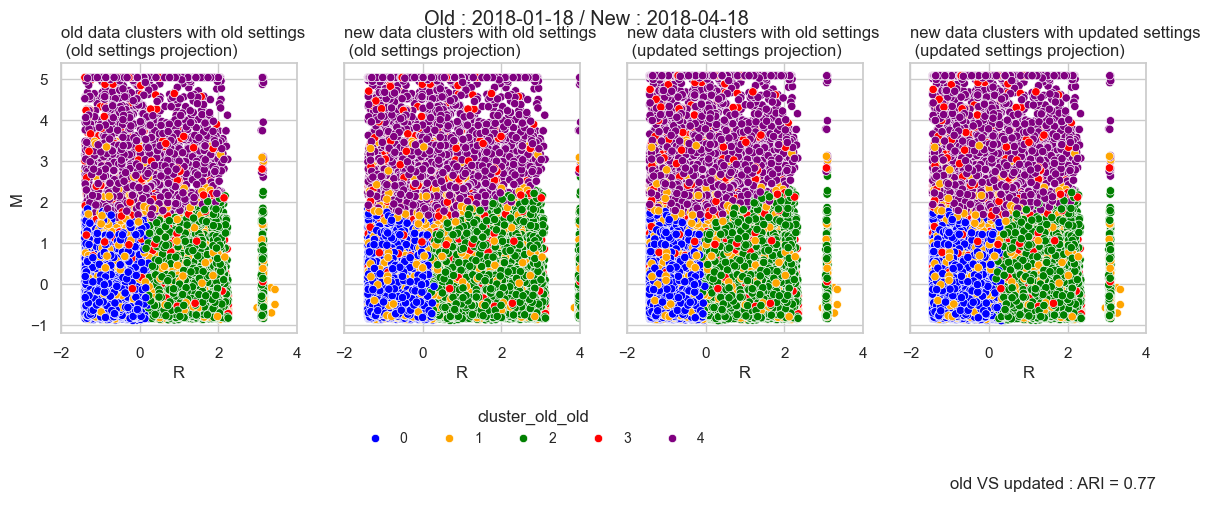

CPU times: total: 4.56 s
Wall time: 8.08 s


In [13]:
%%time
# compare Now and 3 months ago
tNow = dataOrd["order_purchase_timestamp"].max().ceil(
    "d"
) + relativedelta.relativedelta(months=-6)
tPast = tNow + relativedelta.relativedelta(months=-3)

# get RFMDR now and then
RFMDR_now, clients_now = get_RFMDR_date(T_past=tNow, samples=None, random_state=16)
RFMDR_before, clients_past = get_RFMDR_date(
    T_past=tPast, samples=clients_now, random_state=16
)

# compute clusters
(
    clusters_old_old_settings,
    clusters_now_old_settings,
    clusters_now_updated_settings,
    dfs,
) = getOldAndUpdatedClustering(df_before=RFMDR_before, df_now=RFMDR_now, returnDfs=True)

# switch cluster names
clusters_now_updated_settings = adjustClusterLabels(
    clusterSeriesBase=clusters_now_old_settings,
    clusterSeriesToAdjust=clusters_now_updated_settings,
)

# plot differences
plotClusteringOldAndUpdated(
    clusters_old_old_settings=clusters_old_old_settings,
    clusters_now_old_settings=clusters_now_old_settings,
    clusters_now_updated_settings=clusters_now_updated_settings,
    dfs=dfs,
    features=["R", "M"],
    T_past=tPast.date(),
    T_now=tNow.date(),
)

Comme pressenti la correspondance n'est pas bonne.

Sur les 2 features tracées on voit :
- l'impact important du scaling. Par exemple :
    - sur le **premier** graphique, les anciennes données, les valeurs maximales de `R` sont autour de 3 et les valeurs minimales autour de -1.8.
    - sur le **second** graphique, nous avons nos données récentes "scalées" et segmentées avec les anciennes versions :
        - les clients **anciennement les plus récents**, qui ont vu leur `R` augmenter, se sont donc **décalés vers la droite**. De **nouveaux clients** (ou des clients ayant **refait une commande**) **les remplacent**.
        - de la même manière, les clients les plus anciens sont eux maintenant plus proches de 4, leur `R` augmentant. **Les données "s'étirent"**
        - la **limite** entre le cluster des nouveaux clients et le cluster des ex-clients **étant toujours la même**, beaucoup de clients **passent alors d'un cluster à l'autre**...
    - sur le **troisième** graphique, le clustering reste le même mais les données sont représentées après un scaling mis à jour :
        - les valeurs de `R` retournent environ entre 3 et -1.8
        - la **limite** entre les deux mêmes clusters, après **cette contraction**, se **décale vers la gauche**
    - sur le **dernier** graphique, tout est mis à jour :
        - après le bornage, c'est la **limite** entre clusters qui **se positionne de nouveau à peu près comme sur le premier graphique**

## 4.3) Maintenance unique - 1 jour

Lançons un autre test, **cette fois avec une fréquence très faible** :

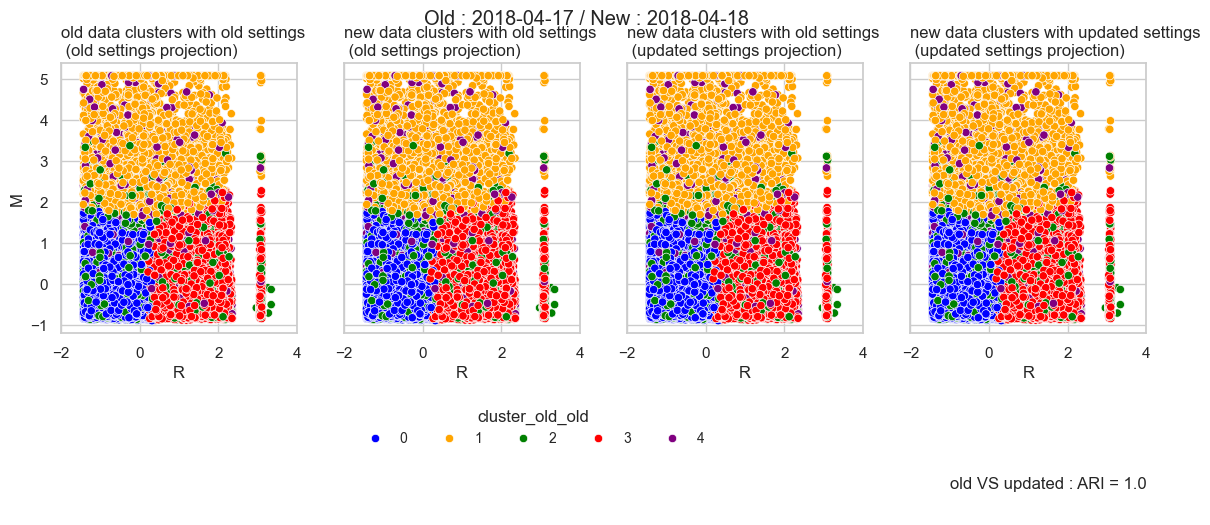

CPU times: total: 4.53 s
Wall time: 8.79 s


In [14]:
%%time
# compare Now and 1 day ago
tNow = dataOrd["order_purchase_timestamp"].max().ceil(
    "d"
) + relativedelta.relativedelta(months=-6)
tPast = tNow + relativedelta.relativedelta(days=-1)

# get RFMDR now and then
RFMDR_now, clients_now = get_RFMDR_date(T_past=tNow, samples=None, random_state=16)
RFMDR_before, clients_past = get_RFMDR_date(
    T_past=tPast, samples=clients_now, random_state=16
)

# compute clusters
(
    clusters_old_old_settings,
    clusters_now_old_settings,
    clusters_now_updated_settings,
    dfs,
) = getOldAndUpdatedClustering(df_before=RFMDR_before, df_now=RFMDR_now, returnDfs=True)

# switch cluster names
clusters_now_updated_settings = adjustClusterLabels(
    clusterSeriesBase=clusters_now_old_settings,
    clusterSeriesToAdjust=clusters_now_updated_settings,
)

# plot differences
plotClusteringOldAndUpdated(
    clusters_old_old_settings=clusters_old_old_settings,
    clusters_now_old_settings=clusters_now_old_settings,
    clusters_now_updated_settings=clusters_now_updated_settings,
    dfs=dfs,
    features=["R", "M"],
    T_past=tPast.date(),
    T_now=tNow.date(),
)

Ici la correspondance est logiquement très bonne !

# 5) Simulation d'opérations de maintenance successives

Nous allons tester différentes fréquences de maintenance : **tous les mois, tous les 15 jours, etc.**. Le tout **sur une période donnée**.

Nous allons donc devoir avoir **besoin de créer différents `RFMDR`s** pour simuler une opération de maintenance.

Par exemple, pour la fréquence "toutes les 3 semaines", nous devons utiliser les `RFMDR`s issus :
- de tout le jeu de données, pour **simuler une opération de maintenance** et **comparer** le résultat du **modèle à jour** avec le **modèle d'il y a 3 semaines**
- du jeu de données d'il y a 3 semaines :
    - pour **paramétrer le modèle de clustering servant de témoin** pour l'opération de maintenance ci-dessus
    - pour **simuler une opération de maintenance** et **comparer** le résultat du **modèle à jour** avec le **modèle d'il y a 6 semaines**
- du jeu de données d'il y a 6 semaines :
    - etc.
    - etc.
- etc.

## 5.1) Création de fonctions pour la simulation

Nous allons utiliser une fonction permettant de simuler des campagnes de maintenance pour différentes fréquences. Pour chaque fréquence `f`, et à partir d'une date de démarrage, la fonction :
- générera les **2** `RFMDR` **espacés de `f` jours**
- effectuera le **test de maintenance** en comparant le **clustering basé sur les anciens paramètres** au **clustering mis à jour**
- **sauvegardera l'`ARI`** calculé
- **avancera** dans le temps **de `f` jours** pour effectuer un nouveau test :
    - le `RFMDR` utilisé **précédemment comme le plus récent** est **alors utilisé comme le plus ancien**
    - **son `preprocessing` et son `KMeans` déjà entraînés** sont alors appliqués **directement sur le nouveau `RFMDR` le plus récent**
    - le clustering est d'un **autre côté totalement mis à jour**
    - le **test `ARI`** est effectué
- et ainsi de suite **jusqu'à une date de fin**

Nous rajouterons des options permettant :
- pour une fréquence donnée, d'arrêter la simulation en cours si l'`ARI` se dégrade un certain nombre fois
- si une fréquence parvient à arriver jusqu'à la date de fin sans chute d'`ARI`, de ne pas prolonger les tests sur la fréquence suivantes

In [15]:
def maintenanceSimulation(
    tested_frequencies,
    T_start,
    T_end,
    ARI_threshold=None,
    accepted_issues=0,
    run_all_freqs=True,
):
    """
    run maintenance simulations for several given frequencies, and return ARI results for each of them

    parameters :
    ------------
    tested_frequencies - list of int : frequencies to be tested, in days
    T_start - timestamp : date on which we begin the simulation
    T_end - timestamp : date on which we end the simulation
    ARI_threshold - float : used to stop the simulation on a frequency if ARI drops under it. By default : None (no early stop)
    accepted_issues - int : the number of times we accept to fail the "ARI_threshold" test. By default : 0 (no tolerance)
    run_all_freqs - bool : wether or not to stop the simulation when one freq achieve complete iteration
                            run without being stopped by ARI criteria. By default : True (run all frequencies)

    return :
    --------
    resultsDict - dictionnary of dataframes : One dataframe for each frequency with one row per test and with columns "T_before","T_after","ARI"

    """

    # test several maintenance frequencies and put ARI results in a dictionnary

    # create dictionnary
    resultsDict = {}

    # compute the number of days between the beginning and the end of the simulation
    totalDays = (T_end - T_start).days

    # iterate on each frequency
    for f in tested_frequencies:
        # compute the total number of periods in totalDays
        nb_periods = int(np.floor(totalDays / f))

        # create a list of periods in days, separating us from the start.
        periodsToExplore = [f * i for i in range(nb_periods)]

        # initiate a dataframe for ARI results
        results = pd.DataFrame(columns=["T_before", "T_after", "ARI"])

        # iterate on each tested period
        for pRef in periodsToExplore:
            ## create RFMDR dataframes

            # for the first test
            if pRef == 0:
                # initiate tested dates : one for old settings, one for updated settings and clustering, separated from f days
                T_before = T_start
                T_after = T_before + pd.Timedelta(days=f)
                # create RFMDR dataframes
                RFMDR_before, _ = get_RFMDR_date(T_past=T_before)
                RFMDR_after, _ = get_RFMDR_date(T_past=T_after)
            # for next tests
            else:
                # this time, the "after" date become the "become" one
                T_before = T_after
                T_after = T_before + pd.Timedelta(days=f)
                # same thing with dataframes
                RFMDR_before = RFMDR_after
                RFMDR_after, _ = get_RFMDR_date(T_past=T_after)

            # if we do not have enough data, skip this iteration and store the information
            if len(RFMDR_before) < 10:
                stopped = True
                continue

            ## run preprocessing and KMeans on old RFMDR

            # for first iteration, initiate a pipeline with scaler and KMeans
            if (pRef == 0) or (stopped == True):
                stopped = False
                # create pipeline steps
                s = StandardScaler()
                kmeans = KMeans(n_init=15, n_clusters=5, random_state=16)
                # create pipeline
                PIPE = Pipeline([("scaler", s), ("KMEANS", kmeans)])
                # fit and predict on Before, and put cluster labels in a Series
                PIPE.fit(RFMDR_before)
                clusters_old_old_settings = PIPE.predict(RFMDR_before)
                clusters_old_old_settings = pd.Categorical(clusters_old_old_settings)
                clusters_old_old_settings = pd.Series(
                    clusters_old_old_settings, name="cluster_old_old"
                )

            # for next iterations, the old clustering with old preprocessing settings is the previous updated one
            else:
                clusters_old_old_settings = clusters_after_updated_settings
                clusters_old_old_settings.name = "cluster_old_old"

            ## predict on RFMDR_after, but with PIPE ALREADY fitted Before

            clusters_after_old_settings = PIPE.predict(RFMDR_after)
            clusters_after_old_settings = pd.Categorical(clusters_after_old_settings)
            clusters_after_old_settings = pd.Series(
                clusters_after_old_settings, name="cluster_after_old"
            )

            ## fit and predict on RFMDR_after, for updated clustering

            PIPE.fit(RFMDR_after)
            clusters_after_updated_settings = PIPE.predict(RFMDR_after)
            clusters_after_updated_settings = pd.Categorical(
                clusters_after_updated_settings
            )
            clusters_after_updated_settings = pd.Series(
                clusters_after_updated_settings, name="cluster_after_updated"
            )

            ## compute ARI
            ari = adjusted_rand_score(
                clusters_after_updated_settings, clusters_after_old_settings
            )

            # store results
            results.loc[pRef] = [T_before, T_after, ari]

            # if ARI_threshold is given, use it
            if ARI_threshold:
                # create a mask with tests where ari < the threshold
                mask = results["ARI"] < ARI_threshold
                # if the number of times the ARI is below threshold is higher than accepted_issues, break
                if len(results.loc[mask]) > accepted_issues:
                    break

        # store results in the dictionnary
        resultsDict[f] = results

        # stop simulation, if wanted, and if the frequency achieved whole run
        if (run_all_freqs == False) and (pRef == periodsToExplore[-1]):
            break

    return resultsDict

Définissons aussi une fonction permettant de tracer les résultats en fonction du temps :

In [16]:
def plotSimulationResults(resultsDict, T_start, T_end, ylim=(0, 1.05)):
    """
    from a given dictionnary containing dataframes of simulation results, plot the ARI results by time

    parameters :
    ------------
    resultsDict - dictionnary of dataframes : One dataframe for each frequency with one row per test
    T_start - timestamp : date on which we begin the simulation
    T_end - timestamp : date on which we end the simulation
    ylim - tuple : y axis limits. By default : (0,1.05)

    output :
    --------
    ARI by time plot

    """

    ## plot the results for each tested frequency

    ## create a figure
    fig, ax = plt.subplots(1, figsize=(14, 10))

    ## for each results, plot ARI by time using the number of days separating the test from the start
    for key, df in resultsDict.items():
        df.reset_index().plot(
            x="index", y="ARI", marker="o", label="f = " + str(key), ax=ax
        )

    ## y axis

    # y label
    ax.set_ylabel("ARI")
    # y ticks
    ax.set_yticks([i / 10 for i in range(11)])
    # y limits
    ax.set_ylim(ylim)

    ## x axis
    # x label
    plt.xlabel("Month")
    # x ticks with the month of testing
    # initiate xitcks and xlabels
    xticks = []
    labels = []
    # compute the total number of days
    totalDays = (T_end - T_start).days
    # convert it in months
    totalMonths = int(np.ceil(totalDays * 12 / 365))

    # iterate on the number of months
    for deltaM in range(totalMonths):
        # offset the date
        T_delta = T_start + relativedelta.relativedelta(months=deltaM, day=1)
        # add the dates offset in days to xticks
        xtick = (T_delta - T_start).days
        xticks.append(xtick)
        # add the month of T_delta to labels
        label = 100 * T_delta.year + T_delta.month
        labels.append(label)
    # add them to fig and add rotation
    plt.xticks(xticks, labels, rotation=45, ha="left")

    # xlim wit offsets of 15 days
    plt.xlim(xticks[0] - 15, xticks[-1] + 15)

    ## title
    plt.title("Maintenance Tests")

    plt.show()

## 5.2) Test préliminaire : sur toute la période d'activité

Essayons tout d'abord d'utiliser :
- **toute la période** couverte par notre jeu de données. Nous avons **vu précédemment que les premiers mois étaient faibles en activité**. Regardons cela de plus près.
- des fréquences assez différentes :
    - **60 jours**, une fréquence de maintenance très lâche de 2 mois
    - **30 jours**, une fréquence de maintenance lâche d'un mois
    - **1 jour**, une fréquence de maintenance extrêmement conservatrice
 
Nous n'utiliserons **pas de critère d'arrêt**.

In [17]:
# end at the earliest date
T_end_1 = dataOrd.order_purchase_timestamp.max().ceil("d")
print("end date :", T_end_1)
# start at the oldest date
T_start_1 = dataOrd.order_purchase_timestamp.min().ceil("d")
print("start date :", T_start_1)

# maintenance frequencies to explore
tested_frequencies_1 = [60, 30, 1]

end date : 2018-10-18 00:00:00
start date : 2016-09-05 00:00:00


In [18]:
%%time
# use maintenanceSimulation function and save the results
if "resultsDict_1.joblib" not in os.listdir("mySaves/maintenance") or (
    rapidProcessing == False
):
    resultsDict_1 = maintenanceSimulation(
        tested_frequencies=tested_frequencies_1,
        T_start=T_start_1,
        T_end=T_end_1,
    )

    dump(resultsDict_1, "mySaves/maintenance/resultsDict_1.joblib")

else:
    resultsDict_1 = load("mySaves/maintenance/resultsDict_1.joblib")

CPU times: total: 0 ns
Wall time: 4 ms


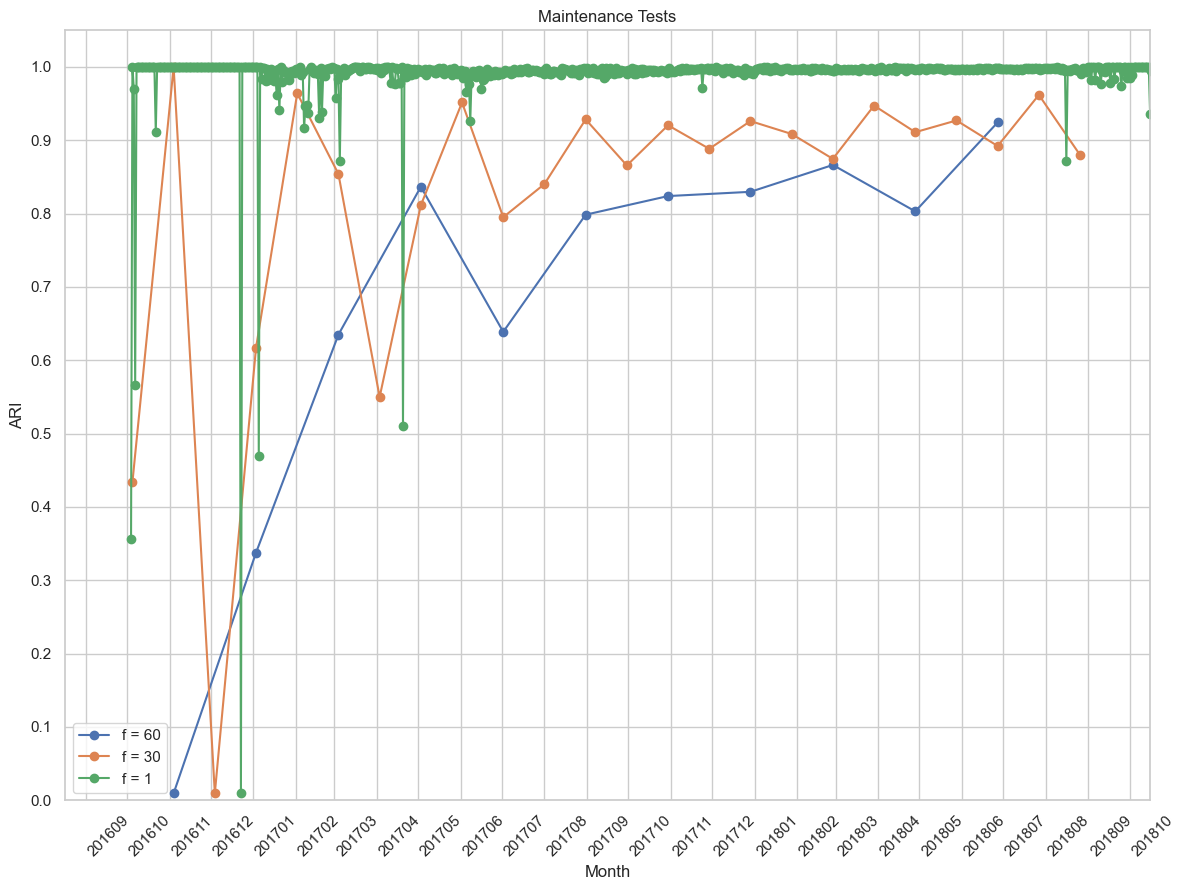

In [19]:
plotSimulationResults(resultsDict_1, T_start_1, T_end_1)

Ce que l'on peut retenir de ce premier test :
- **comme pressenti**, l'utilisation de **toute la période d'activité** de l'entreprise n'est **pas très pertinente** :
    - sur les premières périodes, le manque de commandes/données/activité provoque des chutes d'`ARI` importantes, même pour une fréquence aussi courte que 1 jour...
    - pour prendre en compte cela, nous nous placerons en **mai 2017** pour le démarrage de la simulation.
- les fréquences "2 mois" et "1 mois" sont trop grandes, avec un niveau de correspondance plusieurs fois sous 0.9. **Nous ne les retiendrons pas.**
- la fréquence "1 jour" est trop resserrée, avec des ARI proches de 1 la plupart du temps. Un tel niveau de performance n'est pas nécessaire, et **coûteux**.
- en août 2018, même une fréquence de maintenance aussi basse que 1 jour n'est pas suffisante pour maintenir un ARI au-dessus de 0.9 (voir annexe).

## 5.3) Détermination de la fréquence

Nous pouvons maintenant déterminer notre fréquence de maintenance :
- date de démarrage : **mai 2017**
- date de fin  : **octobre 2018**
- seuil d'`ARI` : **0.9**, **sans tolérance**
- **arrêt anticipé** de la simulation en cas de fréquence gagnante
- fréquences testées : comme nous utiliserons un arrêt anticipé, **nous pouvons aller dans la précision**, car **toutes les valeurs ne seront pas vraiment testées**.

In [20]:
# end at the earliest date
T_end_2 = dataOrd.order_purchase_timestamp.max().ceil("d")
print("end :", T_end_2)
# start with an offset of 17 months
T_start_2 = T_end_2 + relativedelta.relativedelta(months=-17, day=1)
print("start :", T_start_2)

# maintenance frequencies to explore
tested_frequencies_2 = [25, 20, 18, 16, 15, 14, 13, 12, 11, 10, 9, 8]
# tested_frequencies_2 = [17,15,13,11]

end : 2018-10-18 00:00:00
start : 2017-05-01 00:00:00


In [21]:
%%time
# use maintenanceSimulation function and save the results
if "resultsDict_2.joblib" not in os.listdir("mySaves/maintenance") or (
    rapidProcessing == False
):
    resultsDict_2 = maintenanceSimulation(
        tested_frequencies=tested_frequencies_2,
        T_start=T_start_2,
        T_end=T_end_2,
        ARI_threshold=0.9,
        accepted_issues=0,
        run_all_freqs=False,
    )

    dump(resultsDict_2, "mySaves/maintenance/resultsDict_2.joblib")

else:
    resultsDict_2 = load("mySaves/maintenance/resultsDict_2.joblib")

CPU times: total: 0 ns
Wall time: 12.5 ms


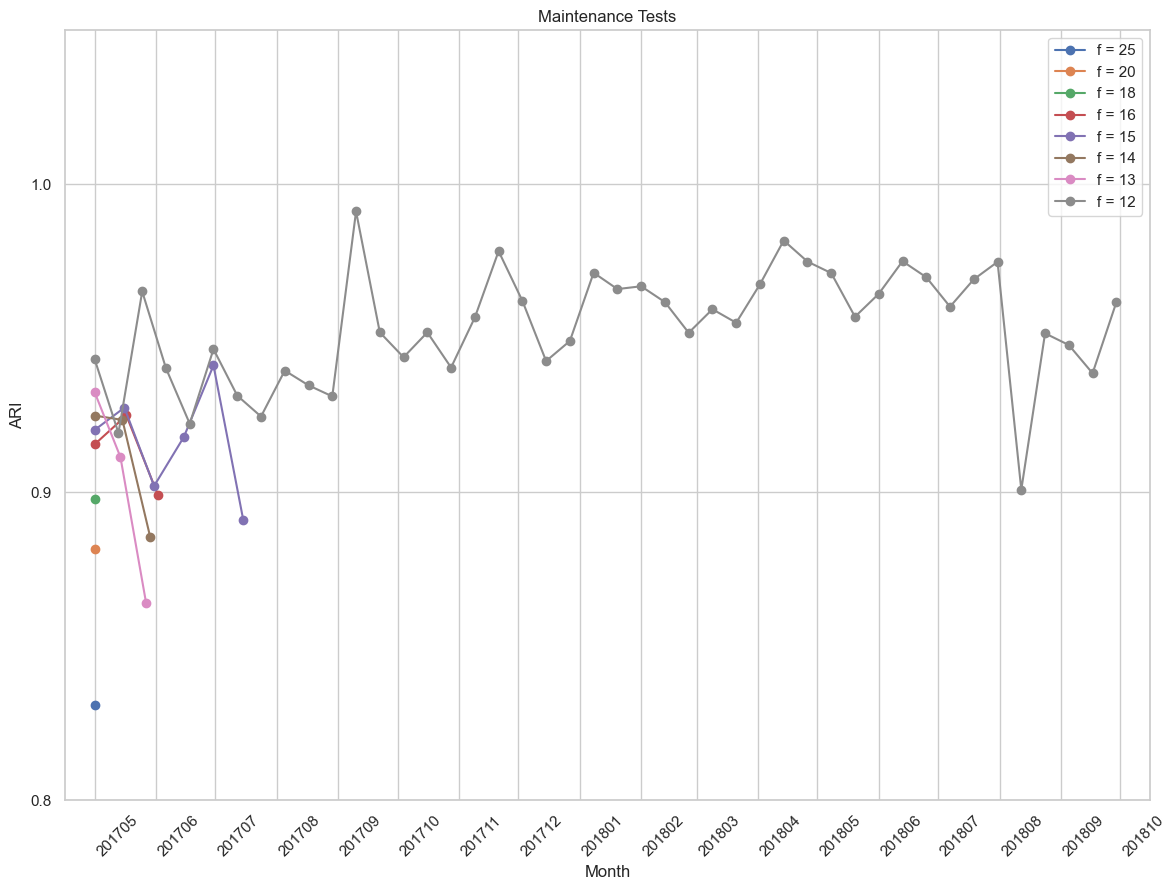

In [22]:
plotSimulationResults(resultsDict_2, T_start_2, T_end_2, ylim=(0.8, 1.05))

# CONCLUSION

Nous proposons une **fréquence de maintenance de 12 jours**, qui au cours de nos simulations à permis de garantir des niveaux de similarité (donnés par l'`ARI`) au-dessus de 0.9 tout au long de la période d'étude.

# ANNEXE : que se passe-t-il en aout 2018 ?

## A.1) Regardons la journée en question

Retrouvons la :

In [23]:
# search for bad ARI in frequence "1 day" results :
# create a mask
mask = resultsDict_1[1]["ARI"] < 0.9
# filter
resultsDict_1[1].loc[mask]

,T_before,T_after,ARI
29,2016-10-04,2016-10-05,0.355872
32,2016-10-07,2016-10-08,0.566087
109,2016-12-23,2016-12-24,0.009361
122,2017-01-05,2017-01-06,0.469580
181,2017-03-05,2017-03-06,0.871231
227,2017-04-20,2017-04-21,0.509685
710,2018-08-16,2018-08-17,0.871382


Le "problème" survient le 17 août 2018 ... Regardons ce qu'il se passe :

In [24]:
# compare 2018-08-16 and 2018-08-17
t17 = dataOrd["order_purchase_timestamp"].max().ceil("d") + relativedelta.relativedelta(
    months=-2, day=17
)
print(t17)
t16 = t17 - pd.Timedelta(days=1)
print(t16)

2018-08-17 00:00:00
2018-08-16 00:00:00


In [25]:
%%time


# get RFMDR at 2018-08-17 and at 2018-08-16
RFMDR_17, _ = get_RFMDR_date(T_past=t17, samples=None, random_state=16)
print("2018-08-17 :", len(RFMDR_now), "clients")
RFMDR_16, _ = get_RFMDR_date(T_past=t16, samples=None, random_state=16)
print("2018-08-16 :", len(RFMDR_before), "clients")

# compute clusters
(
    clusters_16_16_settings,
    clusters_17_16_settings,
    clusters_17_17_settings,
    dfs,
) = getOldAndUpdatedClustering(df_before=RFMDR_16, df_now=RFMDR_17, returnDfs=True)

# switch cluster names
clusters_17_17_settings = adjustClusterLabels(
    clusterSeriesBase=clusters_17_16_settings,
    clusterSeriesToAdjust=clusters_17_17_settings,
)

2018-08-17 : 68241 clients
2018-08-16 : 67984 clients
CPU times: total: 4.95 s
Wall time: 3.27 s


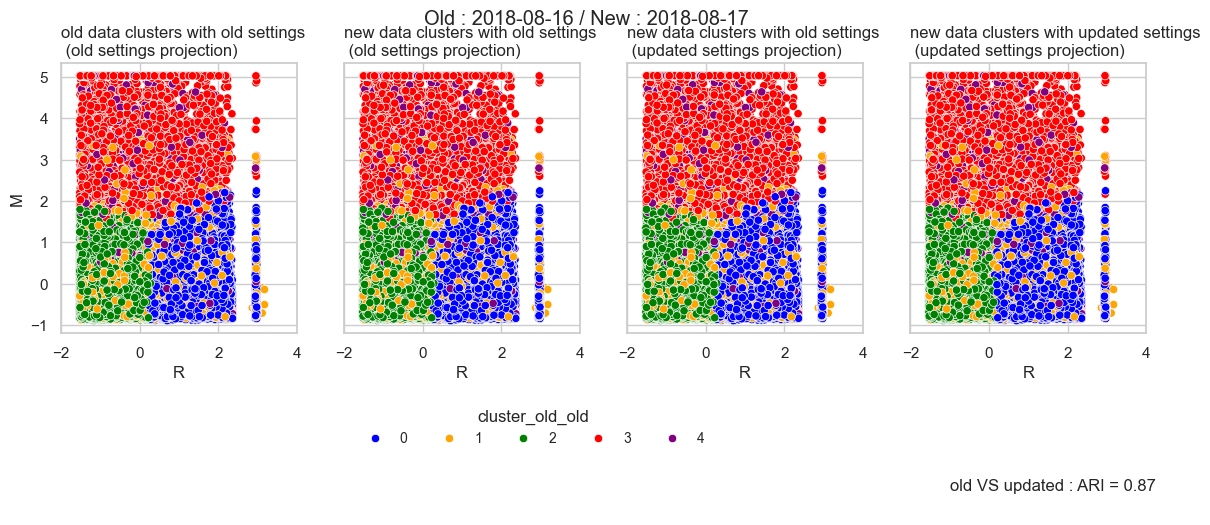

In [26]:
# plot differences
plotClusteringOldAndUpdated(
    clusters_old_old_settings=clusters_16_16_settings,
    clusters_now_old_settings=clusters_17_16_settings,
    clusters_now_updated_settings=clusters_17_17_settings,
    dfs=dfs,
    features=["R", "M"],
    T_past=t16.date(),
    T_now=t17.date(),
)

Un gros groupe de clients passent subitement du cluster **nouveaux clients** au clusters **ex-clients**.



Regardons sur un graphique "non scalé" quelle valeur de `R` est à la limite le 16 août :

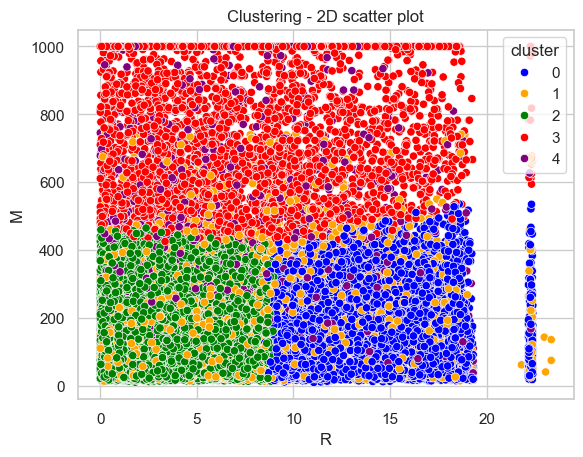

In [27]:
# create a dataframe with 2018-08-16 "R", "M" and clustering
RM_16_and_clusters = RFMDR_16[["R", "M"]].copy()
RM_16_and_clusters["cluster"] = clusters_16_16_settings.values

# plot clustering
mf.clusters_plot2D(RM_16_and_clusters, palette=clusterPalette, equal=False)

La limite se situe environ à `R` = 8 9 mois (pris à partir du 16 août). Or nous avons vu qu'il y avait eu un gros flux de commandes dans la deuxième quinzaine de novembre 2017 !

## A.2) Retrouvons les clients des pics de fin novembre 2017

Ces clients doivent correspondre aux valeurs de `NEW_RECENCE_MONTHS` les plus nombreuses :

In [28]:
# get count of the top 20  unique values of "NEW_RECENCE_MONTHS"
dataOrd.NEW_RECENCE_MONTHS.value_counts().head(10)

NEW_RECENCE_MONTHS
10.75    1141
10.72     444
10.65     396
10.78     394
10.68     390
10.62     377
2.37      370
2.33      368
5.36      367
5.13      364
Name: count, dtype: int64

Cela se confirme, isolons les clients en question :

In [29]:
# filter dataOrd to get orders with "NEW_RECENCE_MONTHS" between 10.42 and 10.78
mask = (dataOrd.NEW_RECENCE_MONTHS >= 10.62) & (dataOrd.NEW_RECENCE_MONTHS <= 10.78)
# display "order_purchase_timestamp" dates
display(dataOrd.loc[mask, "order_purchase_timestamp"].sort_values())
# save clients "customer_unique_id"
clients1711 = dataOrd.loc[mask, "customer_unique_id"].values

34275   2017-11-23 05:40:52
65220   2017-11-23 06:34:25
36520   2017-11-23 06:38:18
61302   2017-11-23 07:17:20
76247   2017-11-23 07:19:20
                ...        
49496   2017-11-29 03:26:00
69888   2017-11-29 03:33:53
96505   2017-11-29 03:36:56
31527   2017-11-29 04:09:01
3367    2017-11-29 04:49:26
Name: order_purchase_timestamp, Length: 3142, dtype: datetime64[ns]

Comparons maintenant l'`ARI` avec et sans ces clients :

In [30]:
# compare ARI with all clients, only with 2017-11 clients and finally with all clients but the 2017-11 ones

# initiate a dataframe
investigation_1617 = pd.DataFrame()
# add an the clients id's
investigation_1617["id"] = RFMDR_17.index
# add clustering, with old settings and with updated settings
investigation_1617["old"] = clusters_17_16_settings
investigation_1617["updated"] = clusters_17_17_settings

# create a mask to filter on 2017-11 clients
mask = investigation_1617["id"].isin(clients1711)

# compute ARIs
reminder_ARI = round(
    adjusted_rand_score(investigation_1617["old"], investigation_1617["updated"]), 2
)
only_201711_clients_ARI = round(
    adjusted_rand_score(
        investigation_1617.loc[mask, "old"], investigation_1617.loc[mask, "updated"]
    ),
    2,
)
without_201711_clients_ARI = round(
    adjusted_rand_score(
        investigation_1617.loc[~mask, "old"], investigation_1617.loc[~mask, "updated"]
    ),
    2,
)

# print results
print("as a reminder, ARI for 2018-08-17 was :", reminder_ARI)
print("only with end of november clients, ARI is :", only_201711_clients_ARI)
print("if we remove them, ARI is :", without_201711_clients_ARI)

as a reminder, ARI for 2018-08-17 was : 0.87
only with end of november clients, ARI is : 0.75
if we remove them, ARI is : 0.92


Les clients issus du pic de commandes de novembre 2017 participent bien fortement à cette dégradation ponctuelle de l'`ARI` survenue avec la fréquence pourtant très faible f = 1 jour.

In [31]:
end_time = time.time()
print("execution time :", int((end_time - start_time) / 60), "min.")

execution time : 0 min.
